## K-NN for Amazon food reviews

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#getting data 
conn = sqlite3.connect('final.sqlite')
final_amazon = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [2]:
def cleanpunc(sentence): 
    '''
    function to clean the word of any punctuation or special characters
    '''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
def cleanhtml(sentence): 
    '''
    function to clean the word of any html-tags
    '''
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [3]:
#getting stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [8]:
#Cleaning sentances
import re
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
stop.remove('very')
i=0
list_of_sent_clean=[]
for sent in final_amazon.CleanedTextBow.values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            cleaned_words = cleaned_words.strip()
            if( (cleaned_words.isalpha()) & \
               (cleaned_words.lower() not in stop ) & \
                (len(cleaned_words)>2)): 
                tmp = lem.lemmatize(cleaned_words.lower())
                filtered_sentence.append(tmp)
            else:
                continue 
    list_of_sent_clean.append(' '.join(filtered_sentence))

In [9]:
#Cleaning summary text
import re
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
i=0
list_of_summary_clean=[]
for sent in final_amazon.Summary.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha() & \
               (cleaned_words.lower() not in stop) & \
                  (len(cleaned_words)>2)): 
                tmp = lem.lemmatize(cleaned_words.lower())
                filtered_sentence.append(tmp)
            else:
                continue 
    list_of_summary_clean.append(' '.join(filtered_sentence))

In [10]:
#concatinating summary text and total text
final_amazon['final_text']= list_of_summary_clean
final_amazon['final_text'] = final_amazon['final_text'] + ' ' + list_of_sent_clean

In [11]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final_clean.sqlite')
c=conn.cursor()
conn.text_factory = str
final_amazon.to_sql('Reviews_final', conn, flavor=None, schema=None,
             if_exists='replace', index=True, 
                    index_label=None, chunksize=None, dtype=None)

In [3]:
conn = sqlite3.connect('final_clean.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [4]:
#Sampling data 
s = final_review.sample(n=70000,random_state=0)

In [5]:
s.drop('level_0',axis=1,inplace=True)

In [6]:
#information about data
s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 68546 to 359470
Data columns (total 14 columns):
index                     70000 non-null int64
Id                        70000 non-null int64
ProductId                 70000 non-null object
UserId                    70000 non-null object
ProfileName               70000 non-null object
HelpfulnessNumerator      70000 non-null int64
HelpfulnessDenominator    70000 non-null int64
Score                     70000 non-null object
Time                      70000 non-null int64
Summary                   70000 non-null object
Text                      70000 non-null object
CleanedText               70000 non-null object
CleanedTextBow            70000 non-null object
final_text                70000 non-null object
dtypes: int64(5), object(9)
memory usage: 8.0+ MB


In [7]:
#SORT by time for TBS
s = s.sort_values(by='Time')

In [8]:
#changing lables to 1 or 0
s.Score = s.Score.apply(lambda x:
                     1 if x == 'positive' else 0)

In [9]:
#Converting to int8
s.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
s.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [10]:
round(s.shape[0]*0.70) + round(s.shape[0]*0.30)

70000

In [11]:
#Splitting Dataframe for train and test
train_df = s.iloc[:round(s.shape[0]*0.70),:]
test_df = s.iloc[round(s.shape[0]*0.70):,:]

In [12]:
#saving to disk
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [15]:
print(train_df.shape)
print(test_df.shape)

(49000, 14)
(21000, 14)


### Bag of Words

In [20]:
#traing scores for each k between 1-15
list1 = list(range(1,16,2))
list1.append(25)
scores_train = []
for k in list1:
    #CountVectorizer for BoW
    count_vect = CountVectorizer(dtype=np.int8)
    final_counts_train = count_vect.fit_transform(
    train_df['final_text'].values)
    X = final_counts_train.toarray()
    #knn instance
    model_knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    model_knn.fit(X,train_df.Score)
    #Predicting training data
    train_list = model_knn.predict(X)
    #Accuracy score
    score_train = accuracy_score(train_df.Score,train_list)
    scores_train.append(score_train)
#saving for further use
pickle.dump(scores_train,open('scores_train.p','wb'))

In [29]:
scores_train = pickle.load(open('scores_train.p','rb'))

In [22]:
print('train score corresponding to k value ')
i = 0
for k in list1:  
    print(k, ' ', scores_train[i])
    i= i + 1

train score corresponding to k value 
1   1.0
3   0.9140408163265306
5   0.8932448979591837
7   0.8848163265306123
9   0.879
11   0.8758571428571429
13   0.8724897959183674
15   0.8704285714285714
25   0.865


In [15]:
#10 fold crossvalidation splits for Time series data
tscv_10 = TimeSeriesSplit(n_splits=10)

In [17]:
#time series data cross validation 10 fold
scores_bow_cv = []
for k in list1:
    scores = []
    #10 fold cv
    for train_idx,test_idx in tscv_10.split(train_df):
        count_vect = CountVectorizer(dtype=np.int8)
        #train data
        X_train = train_df.iloc[train_idx]
        #test data
        X_test = train_df.iloc[test_idx]
        #bow wit train data
        final_counts_train = count_vect.fit_transform(
        X_train['final_text'].values)
        X = final_counts_train.toarray()
        #knn instance wit kd tree
        model_knn = KNeighborsClassifier(n_neighbors=k,
                            algorithm='kd_tree',n_jobs=-1)
        model_knn.fit(X,X_train.Score)
        #bow transform for test data
        final_counts_test = count_vect.transform(
        X_test['final_text'].values)
        X_test_array = final_counts_test.toarray()
        #predicting test data
        test_list = model_knn.predict(X_test_array)
        #test accuracy for cv fold
        score = accuracy_score(X_test.Score,test_list)
        scores.append(score)
    scores_bow_cv.append(scores)
#saving to disk for furter use 
pickle.dump(scores_bow_cv,open('scores_bow_cv.p','wb'))

In [30]:
scores_bow_cv = pickle.load(open('scores_bow_cv.p','rb'))

In [31]:
print(len(scores_bow_cv))
print(len(scores_bow_cv[0]))

9
10


In [23]:
#mean cv scores
mean_cv = np.array(scores_bow_cv).mean(axis=1)
mean_cv

array([0.81082173, 0.84811405, 0.85071846, 0.84838348, 0.8473956 ,
       0.84694656, 0.84654243, 0.84631792, 0.84584643])

In [24]:
std_cv = np.array(scores_bow_cv).std(axis=1)
std_cv

array([0.01058437, 0.01332477, 0.01719177, 0.0185471 , 0.01898892,
       0.01911855, 0.01936252, 0.01954648, 0.01990145])

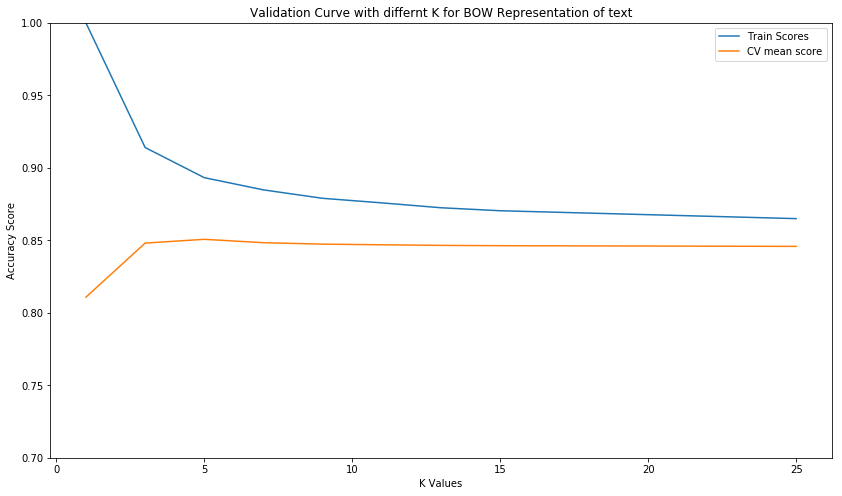

In [28]:
plt.figure(figsize=(14,8))
plt.plot(list1,
         scores_train,label='Train Scores')
plt.plot(list1,
         mean_cv,label = 'CV mean score')
plt.xlabel('K Values')
plt.ylabel('Accuracy Score')
plt.ylim(0.7,1)
plt.title('Validation Curve with differnt K for BOW Representation of text')
plt.legend()

In [137]:
model_knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model_knn.fit(X,train_df.Score)
test_list = model_knn.predict(X_test)
score = accuracy_score(test_df.Score,test_list)
print('k = 5' , score)

k = 5 0.8494285714285714


#### Observation: 
* For k = 5 the cv accuracy is high with mean 0.85071846 standard deviation of 0.01719177 for 10 fold cross validation. 
* For k > 5 the cv mean accuracy is decresing and train accuracy is also decresing. 
* Test accuracy for k =5 is 0.8494285714285714

### TR-IDF:

In [29]:
#k values
list_tfidf = list(range(1,18,2))
list_tfidf.extend([25,27,37,51,71,101])

In [40]:
scores_train_tfidf= []
#train scores for different k values of tfidf representation
for i in list_tfidf:
    #tfidf
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    final_tf_idf = tf_idf_vect.fit_transform(train_df['final_text'].values)
    #scaling sparse array
    scale = StandardScaler(with_mean=False)
    X = scale.fit_transform(final_tf_idf)
    #knn wit brute force algorithm
    model_knn = KNeighborsClassifier(n_neighbors=i,
                            algorithm='brute',n_jobs=-1)
    model_knn.fit(X,train_df.Score)
    #predicting train scores
    test_list = model_knn.predict(X)
    #accuracy score
    score_train = accuracy_score(train_df.Score,test_list)
    scores_train_tfidf.append(score_train)   
pickle.dump(scores_train_tfidf,open('scores_train_tfidf.p','wb'))

In [32]:
scores_train_tfidf = pickle.load(open('scores_train_tfidf.p','rb'))
len(scores_train_tfidf)

15

In [31]:
print('train score corresponding to k value ')
i = 0
for k in list_tfidf:  
    print(k, ' ', scores_train_tfidf[i])
    i= i + 1

train score corresponding to k value 
1   1.0
3   0.8504897959183674
5   0.8499795918367347
7   0.8498571428571429
9   0.8498571428571429
11   0.8498571428571429
13   0.8498571428571429
15   0.8498571428571429
17   0.8498571428571429
25   0.8498571428571429
27   0.8498571428571429
37   0.8498571428571429
51   0.8498571428571429
71   0.8498571428571429
101   0.8498571428571429


In [46]:
#10 fold cv
tscv_10 = TimeSeriesSplit(n_splits=10)
scores_testcv_tfidf = []
for i in list_tfidf:
    scores_test = []
    #for each fold
    for train_idx,test_idx in tscv_10.split(train_df):
        tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
        #train data
        X_train = train_df.iloc[train_idx]
        #cv data
        X_test = train_df.iloc[test_idx]
        #tfidf
        final_tf_idf = tf_idf_vect.fit_transform(X_train['final_text'].values)
        scale = StandardScaler(with_mean=False)
        X = scale.fit_transform(final_tf_idf)
        #knn
        model_knn = KNeighborsClassifier(n_neighbors=i,
                            algorithm='brute',n_jobs=-1)
        model_knn.fit(X,X_train.Score)
        #cv data tfidf representation
        final_counts_test = tf_idf_vect.transform(
        X_test['final_text'].values)
        X_test_array = scale.transform(final_counts_test)
        #prdicting cv data
        test_list = model_knn.predict(X_test_array)
        #accuracy of cv data
        score_test = accuracy_score(X_test.Score,test_list)
        scores_test.append(score_test)
    scores_testcv_tfidf.append(scores_test)    
pickle.dump(scores_testcv_tfidf,open('score_testcv_tfidf.p','wb'))

In [33]:
scores_testcv_tfidf = pickle.load(open('score_testcv_tfidf.p','rb'))
print(len(scores_testcv_tfidf))
print(len(scores_testcv_tfidf[0]))

15
10


In [33]:
#mean cv sores
mean_cv = np.array(scores_testcv_tfidf).mean(axis=1)
mean_cv

array([0.84577907, 0.84568927, 0.84568927, 0.84568927, 0.84568927,
       0.84568927, 0.84568927, 0.84568927, 0.84568927, 0.84568927,
       0.84568927, 0.84568927, 0.84568927, 0.84568927, 0.84568927])

In [34]:
#standard deviation of cv scores
std_cv = np.array(scores_testcv_tfidf).std(axis=1)
std_cv

array([0.01993593, 0.02002439, 0.02002439, 0.02002439, 0.02002439,
       0.02002439, 0.02002439, 0.02002439, 0.02002439, 0.02002439,
       0.02002439, 0.02002439, 0.02002439, 0.02002439, 0.02002439])

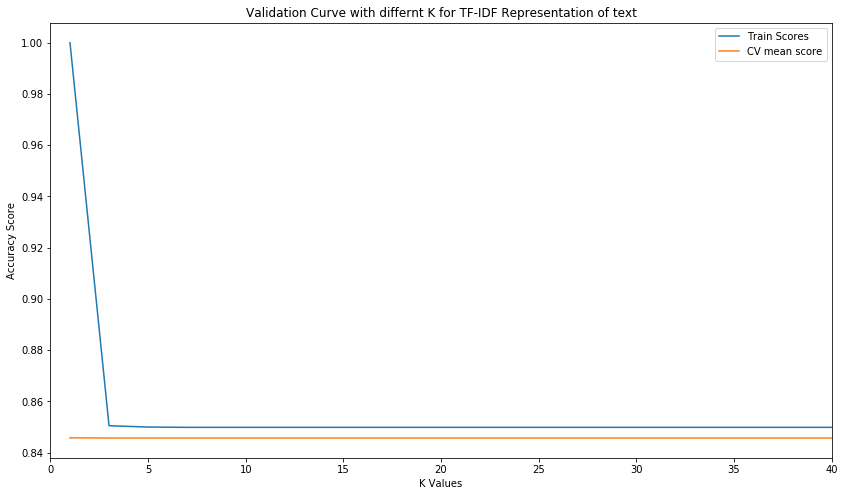

In [35]:
plt.figure(figsize=(14,8))
plt.plot(list_tfidf,
         scores_train_tfidf,label='Train Scores')
plt.plot(list_tfidf,
         mean_cv,label = 'CV mean score')
plt.xlabel('K Values')
plt.ylabel('Accuracy Score')
plt.xlim(0,40)
plt.title('Validation Curve with differnt K for TF-IDF Representation of text')
plt.legend()

#### Observations: 
* for k > 3 cv scores are same and for k > 5 the training scores are also same. so it is better to take k in range of 25-50 like that because if we take less value of k it may cause overfit. so i made optimal k as 25. if need of speed computation on test data we can prefer k as 5

In [83]:
#test score for k = 25
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(train_df['final_text'].values)
scale = StandardScaler(with_mean=False)
X = scale.fit_transform(final_tf_idf)
model_knn = KNeighborsClassifier(n_neighbors=25,
                      algorithm='brute',n_jobs=-1)
model_knn.fit(X,train_df.Score)
X_test =  tf_idf_vect.transform(test_df['final_text'].values)
X_test = scale.transform(X_test)
test_list = model_knn.predict(X_test)
score_test = accuracy_score(test_df.Score,test_list)
score_test

0.8257619047619048

### Word2Vec

In [16]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [85]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [87]:
#word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=8)

In [88]:
#saving to disk
pickle.dump(w2v_model,open('w2v_model.p','wb'))

In [17]:
w2v_model = pickle.load(open('w2v_model.p','rb'))

#### Avg Word2Vec

In [116]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model):
    '''
    Returns average of word vectors for 
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(50)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [117]:
#avg word vectors
sent_vectors = avg_w2v(list_of_sent,w2v_model)
len(sent_vectors)

364171

In [159]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())

In [148]:
#avg word2vec for 
sent_vector_avgw2v = avg_w2v(list_of_sent_train,w2v_model)

In [149]:
#stacking columns
train_avgw2v = np.hstack((sent_vector_avgw2v,
            train_df[['HelpfulnessNumerator',
                      'HelpfulnessDenominator','Score']]))
column = list(range(0,50))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
train_df_avgw2v = pd.DataFrame(train_avgw2v,columns=column)

In [164]:
#saving
train_df_avgw2v.to_csv('train_df_avgw2v.csv',index=False)

In [4]:
train_df_avgw2v = pd.read_csv('train_df_avgw2v.csv')

In [166]:
#test data
list_of_sent_test=[]
for sent in test_df.final_text.values:
    list_of_sent_test.append(sent.split())

In [167]:
#test data avg word2vec
sent_vector_avgw2v = avg_w2v(list_of_sent_test,w2v_model)

In [168]:
#stacking for test data
test_avgw2v = np.hstack((sent_vector_avgw2v,
            test_df[['HelpfulnessNumerator',
                      'HelpfulnessDenominator','Score']]))
column = list(range(0,50))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
test_df_avgw2v = pd.DataFrame(test_avgw2v,columns=column)

In [170]:
test_df_avgw2v.to_csv('test_df_avgw2v.csv',index=False)

In [6]:
test_df_avgw2v = pd.read_csv('test_df_avgw2v.csv')

In [38]:
list_avgw2v = list(range(1,18,2))
list_avgw2v.extend([25,35,45,55,95])

In [105]:
#train scores for each k with avgword2vec 
scores_train_avgw2v = []
for k in list_avgw2v:
    #scaling
    scale = StandardScaler()
    X = scale.fit_transform(train_df.drop('Score',axis=1))
    #knn with ball tree
    model_knn = KNeighborsClassifier(n_neighbors=k,
                        algorithm='ball_tree',n_jobs=-1)
    model_knn.fit(X,train_df.Score)
    #train accuracy
    score_train = model_knn.score(X,train_df.Score)
    scores_train_avgw2v.append(score_train)
pickle.dump(scores_train_avgw2v,open('scores_train_avgw2v.p','wb'))

In [34]:
#loading
scores_train_avgw2v = pickle.load(open('scores_train_avgw2v.p','rb'))

In [40]:
print('train score corresponding to k value ')
i = 0
for k in list_avgw2v:  
    print(k, ' ', scores_train_avgw2v[i])
    i= i + 1

train score corresponding to k value 
1   1.0
3   0.9378775510204082
5   0.9230612244897959
7   0.9160204081632654
9   0.9118775510204081
11   0.908795918367347
13   0.9065918367346939
15   0.904469387755102
17   0.9033877551020408
25   0.898795918367347
35   0.8950816326530612
45   0.8921632653061224
55   0.8905714285714286
95   0.8862857142857142


In [90]:
#10 fold cv
tscv_10 = TimeSeriesSplit(n_splits=10)
scores_avgw2v_cv = []
for k in list_avgw2v:
    scores_test = []
    for train_idx,test_idx in tscv_10.split(train_df):
        #train data
        X_train = train_df.iloc[train_idx]
        #cv data
        X_test = train_df.iloc[test_idx]
        #Scale
        scale = StandardScaler()
        X = scale.fit_transform(X_train.drop('Score',axis=1))
        #knn
        model_knn = KNeighborsClassifier(n_neighbors=45,
                            algorithm='ball_tree',n_jobs=-1)
        model_knn.fit(X,X_train.Score)
        #cv data scaling
        X_test_array = scale.transform(X_test.drop('Score',axis=1))
        #predicting cv data
        test_list = model_knn.predict(X_test_array)
        #test accuracy
        score_test = accuracy_score(X_test.Score,test_list)
        scores_test.append(score_test)
    scores_avgw2v_cv.append(scores_test)
pickle.dump(scores_avgw2v_cv,open('scores_avgw2v_cv.p','wb'))

In [41]:
scores_avgw2v_cv = pickle.load(open('scores_avgw2v_cv.p','rb'))

In [42]:
#mean cv scores
mean_cv = np.array(scores_avgw2v_cv).mean(axis=1)
mean_cv

array([0.86234845, 0.88206107, 0.88527167, 0.88542883, 0.88524921,
       0.88520431, 0.88394701, 0.88365514, 0.88259991, 0.8798608 ,
       0.87723395, 0.87581949, 0.87462955, 0.86962281])

In [43]:
#std of cv scores
std_cv = np.array(scores_avgw2v_cv).std(axis=1)
std_cv

array([0.01129099, 0.00897735, 0.00805013, 0.00777365, 0.00718627,
       0.00784851, 0.00829344, 0.00813781, 0.00821834, 0.00811899,
       0.009041  , 0.00941338, 0.00942074, 0.00990732])

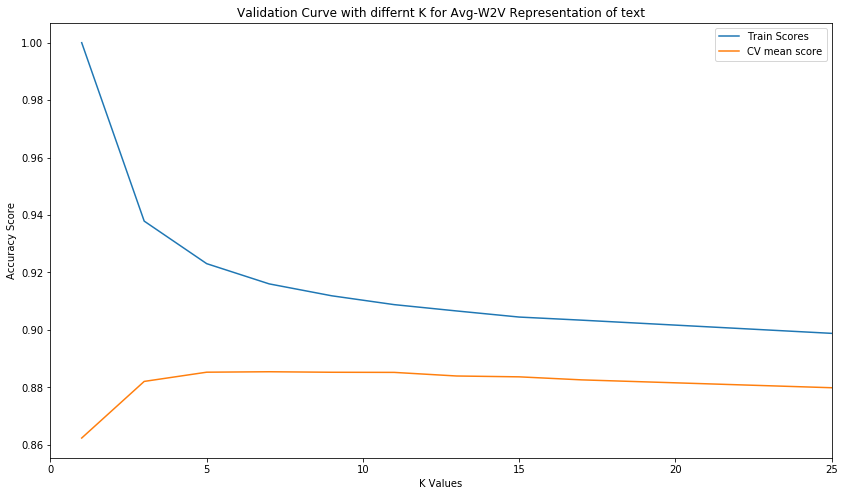

In [45]:
plt.figure(figsize=(14,8))
plt.plot(list_avgw2v,
         scores_train_avgw2v,label='Train Scores')
plt.plot(list_avgw2v,
         mean_cv,label = 'CV mean score')
plt.xlabel('K Values')
plt.ylabel('Accuracy Score')
plt.xlim(0,25)
plt.title('Validation Curve with differnt K for Avg-W2V Representation of text')
plt.legend()

#### Observations:
* From above we can infer that 7 or 11 be optimal k. Train and test accureacy are below mentiond. after 11 cross validation accuracy is decresing and training also decresing. 

In [46]:
#test scores
for k in [7,11]:
    scale = StandardScaler()
    X = scale.fit_transform(train_df.drop('Score',axis=1))
    model_knn = KNeighborsClassifier(n_neighbors=k,algorithm='ball_tree',n_jobs=-1)
    model_knn.fit(X,train_df.Score)
    X_test = scale.transform(test_df.drop('Score',axis=1))
    score_test = model_knn.score(X_test,test_df.Score)
    score_train = model_knn.score(X,train_df.Score)
    print('k = ',k)
    print('Training Score',score_train)
    print('Testing Score',score_test)

k =  7
Training Score 0.9160204081632654
Testing Score 0.8811904761904762
k =  11
Training Score 0.908795918367347
Testing Score 0.8807142857142857


#### TF-IDF Weighted Word2Vec

In [16]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [19]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(final_review.final_text.values)

In [56]:
#dict wit value as index
dict_tfidf = {k: v for v, k in enumerate(tf_idf_vect.get_feature_names())}

In [53]:
%%time
#time for for loop implementation
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50,dtype=np.float64) # as word vectors are of zero length
    weight_sum =0.0; # num of words with a valid vector in the sentence/review
    for word in sent : # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, dict_tfidf[word]]
            sent_vec = sent_vec + vec*tfidf
            weight_sum = weight_sum + tfidf
        except:
            pass
    sent_vec = sent_vec/weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 6min 15s, sys: 22.8 s, total: 6min 38s
Wall time: 6min 12s


In [22]:
def tf_idf_W2V(w2v_model,tf_idf_vect,tf_idf_trans_arr,list_of_sent):
    import operator
    dict_tfidf = {k: v for v, k in enumerate(tf_idf_vect.get_feature_names())}
    sent_vectors = []
    i = 0
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in w2v_model.wv.vocab]
        if doc:
            #itemgetter
            f = operator.itemgetter(*doc)
            try:
                #itemgetter from dict
                final = f(dict_tfidf)
                final = tf_idf_trans_arr[i,final]
                #converting to dense
                final = final.toarray()
                #converting to diagnol matrix for multiplication
                final= np.diag(final[0])
                sent_vec = np.dot(final,np.array(w2v_model.wv[doc]))
                #tfidf weighted word to vec
                sent_vec = np.sum(sent_vec,axis=0) / np.sum(final)
            except:
                sent_vec = np.zeros(50)             
        else:
            sent_vec = np.zeros(50)
        sent_vectors.append(sent_vec)
        i = i+1
    return sent_vectors

In [49]:
#time for vectorized implementation
%time test = tf_idf_W2V(w2v_model,tf_idf_vect,final_tf_idf,list_of_sent)

CPU times: user 3min 58s, sys: 362 ms, total: 3min 58s
Wall time: 3min 58s


In [57]:
 tfidf_sent_vectors[300]

array([-0.50473002, -1.29254243, -1.14878999,  0.16220791, -1.57725931,
        0.33451035, -0.85590403, -0.99547177,  0.35920219,  0.35229029,
        0.48958326, -0.72000141, -0.63554757, -0.93693301, -0.48698263,
        0.47417588,  0.68699963,  1.06305276, -0.68265815, -1.3964433 ,
        0.03462894, -0.5222669 ,  0.36551395,  0.44783677, -0.19720486,
        0.23341387, -0.25774105,  0.80620439,  0.74853232, -0.14239912,
       -0.40646785, -0.18689983,  0.83903254,  0.07734973,  0.08818401,
       -0.3893744 , -0.26932468,  0.32558248, -1.17318695, -1.2369735 ,
        0.42737041,  0.67004039, -0.13578889, -0.45484249,  0.9743006 ,
        0.73795557,  0.69694404,  0.26626051,  0.05896904, -0.95720778])

In [58]:
test[300]

array([-0.50473004, -1.29254244, -1.14879001,  0.16220793, -1.57725938,
        0.33451035, -0.85590406, -0.99547177,  0.35920219,  0.3522903 ,
        0.48958326, -0.72000142, -0.6355476 , -0.93693305, -0.48698265,
        0.47417587,  0.68699964,  1.06305275, -0.68265816, -1.39644332,
        0.03462894, -0.52226692,  0.36551395,  0.44783678, -0.19720486,
        0.23341385, -0.25774106,  0.80620441,  0.74853235, -0.14239914,
       -0.40646785, -0.18689983,  0.8390326 ,  0.07734973,  0.088184  ,
       -0.3893744 , -0.2693247 ,  0.32558251, -1.17318696, -1.23697357,
        0.42737042,  0.67004042, -0.13578887, -0.45484252,  0.97430062,
        0.73795559,  0.69694405,  0.26626052,  0.05896904, -0.95720779])

Vectorized implementation is around 65% faster than normal for loop implementation. so i used vectorized implementation for claculating tfidf weighted word2vec. but this need more space than loop implementation.

In [18]:
#list of k
list_tfidf_w2v = list(range(1,26,2))
list_tfidf_w2v.extend([35,45,95])

In [230]:
print('train score corresponding to k value ')
#tfidf instance
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(train_df['final_text'].values)
list_of_sent = []
#converting into list of words for each sentance of train
for sent in train_df.final_text.values:
    list_of_sent.append(sent.split())
#getting tfidf weighted word to vec 
X_train_fet = tf_idf_W2V(w2v_model,tf_idf_vect,final_tf_idf,list_of_sent)
X_train_fet = np.hstack((X_train_fet,
            train_df[['HelpfulnessNumerator',
                      'HelpfulnessDenominator']]))
#scaling
scale = StandardScaler()
X = scale.fit_transform(X_train_fet)
for k in list_tfidf_w2v:
    #knn with ball tree
    model_knn = KNeighborsClassifier(n_neighbors=k,
                            algorithm='ball_tree',n_jobs=-1)
    model_knn.fit(X_train_fet,train_df.Score)
    #accuracy of train 
    score_train = model_knn.score(X_train_fet,train_df.Score)
    scores_train.append(score_train)
    print(k, ' ', scores_train)
#saving
pickle.dump(scores_train,open('score_tfidfw2v_train1to19.p','wb'))

train score corresponding to k value 
1   1.0
3   0.934734693877551
5   0.9206530612244898
7   0.9123877551020408
9   0.909
11   0.9058571428571428
13   0.9034489795918368
15   0.9009387755102041
17   0.9
19   0.8984489795918368
21   0.897673469387755
23   0.8967142857142857
25   0.8958571428571429
35   0.8929387755102041
45   0.8910204081632653
95   0.884


In [2]:
score_train_tfidf_w2v = pickle.load(open('score_train_tfidf_w2v.p','rb'))

In [223]:
#10 fold cv
tscv_10 = TimeSeriesSplit(n_splits=10)
score_cv_tfidf_w2v = []
for k in list_tfidf_w2v:
    scores_test = []
    #for each cv fold
    for train_idx,test_idx in tscv_10.split(train_df):
        #train data
        X_train = train_df.iloc[train_idx]
        #cv data
        X_test = train_df.iloc[test_idx]
        #tfidf
        tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
        final_tf_idf = tf_idf_vect.fit_transform(X_train['final_text'].values)
        list_of_sent = []
        for sent in X_train.final_text.values:
            list_of_sent.append(sent.split())
        #tfidf weighted word2vec 
        X_train_fet = tf_idf_W2V(w2v_model,tf_idf_vect,
                            final_tf_idf,list_of_sent)
        #stacking word vec and some other features
        X_train_fet = np.hstack((X_train_fet,
                X_train[['HelpfulnessNumerator',
                      'HelpfulnessDenominator']]))
        #scaling
        scale = StandardScaler()
        X = scale.fit_transform(X_train_fet)
        #knn
        model_knn = KNeighborsClassifier(n_neighbors=21,
                                    algorithm='ball_tree',n_jobs=-1)
        model_knn.fit(X_train_fet,X_train.Score)
        #cv data transformation to tfidf
        final_tf_idf_test = tf_idf_vect.transform(X_test['final_text'].values)
        list_of_sent = []
        for sent in X_test.final_text.values:
            list_of_sent.append(sent.split())
        #word2vec for cv data
        X_test_fet = tf_idf_W2V(w2v_model,tf_idf_vect,final_tf_idf_test,list_of_sent)
        X_train_fet = np.hstack((X_test_fet,
                X_test[['HelpfulnessNumerator',
                      'HelpfulnessDenominator']]))
        X_test_array = scale.transform(X_train_fet)
        test_list = model_knn.predict(X_test_array)
        #accuracy of cv data
        score_test = accuracy_score(X_test.Score,test_list)
        scores_test.append(score_test)
    score_cv_tfidf_w2v.append(scores_test)
pickle.dump(score_cv_tfidf_w2v,open('score_cv_tfidf_w2v.p','wb'))

In [3]:
score_cv_tfidf_w2v = pickle.load(open('score_cv_tfidf_w2v.p','rb'))

In [21]:
print(len(score_cv_tfidf_w2v))
print(len(score_cv_tfidf_w2v[0]))

16
10


In [239]:
#mean cv scores
mean_cv = np.array(score_cv_tfidf_w2v).mean(axis=1)
mean_cv

array([0.84833857, 0.86349349, 0.86273013, 0.86306691, 0.86169735,
       0.86066457, 0.86019308, 0.85940727, 0.85893579, 0.85864392,
       0.85821733, 0.8578132 , 0.85734172, 0.85597216, 0.85480467,
       0.85215537])

In [4]:
std_cv = np.array(score_cv_tfidf_w2v).std(axis=1)
std_cv

array([0.01451891, 0.01193917, 0.01315763, 0.01381154, 0.01425322,
       0.01390058, 0.01384566, 0.01374618, 0.01385293, 0.01398445,
       0.01409291, 0.01398332, 0.01413468, 0.01445663, 0.01464605,
       0.01575441])

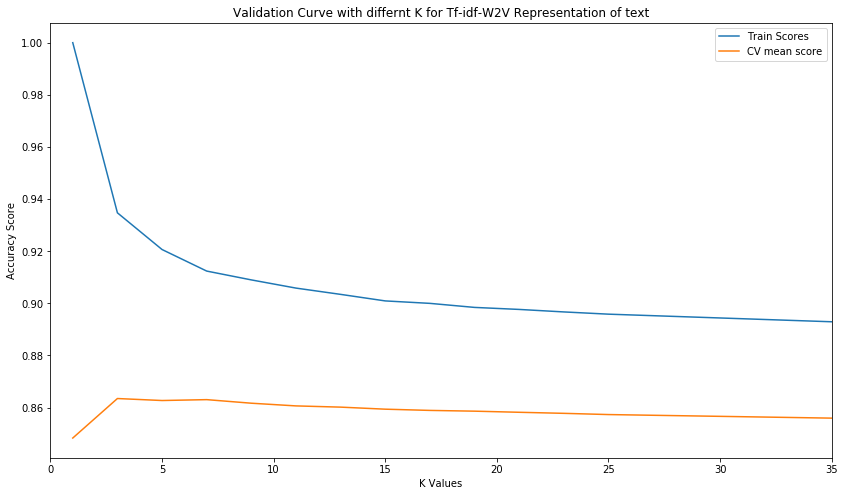

In [245]:
plt.figure(figsize=(14,8))
plt.plot(list_tfidf_w2v,
         score_train_tfidf_w2v,label='Train Scores')
plt.plot(list_tfidf_w2v,
         mean_cv,label = 'CV mean score')
plt.xlabel('K Values')
plt.ylabel('Accuracy Score')
plt.xlim(0,35)
plt.title('Validation Curve with differnt K for Tf-idf-W2V Representation of text')
plt.legend()

#### Observations:<br>
Cross validation score is maximum at 3,7 and after that cv score is decresing. below are the train and test scores for k = 3,7

In [28]:
for k in [3,7]:
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
    final_tf_idf = tf_idf_vect.fit_transform(train_df['final_text'].values)
    list_of_sent = []
    for sent in train_df.final_text.values:
        list_of_sent.append(sent.split())
    X_train_fet = tf_idf_W2V(w2v_model,tf_idf_vect,final_tf_idf,list_of_sent)
    X_train_fet = np.hstack((X_train_fet,
            train_df[['HelpfulnessNumerator',
                      'HelpfulnessDenominator']]))
    scale = StandardScaler()
    X = scale.fit_transform(X_train_fet)
    model_knn = KNeighborsClassifier(n_neighbors=k,algorithm='ball_tree',n_jobs=-1)
    model_knn.fit(X_train_fet,train_df.Score)
    score_train = model_knn.score(X_train_fet,train_df.Score)
    list_of_sent = []
    for sent in test_df.final_text.values:
        list_of_sent.append(sent.split())
    final_tf_idf_test = tf_idf_vect.transform(test_df['final_text'].values)
    X_test_fet = tf_idf_W2V(w2v_model,tf_idf_vect,final_tf_idf_test,list_of_sent)
    print(X_test_fet)
    X_train_fet = np.hstack((X_test_fet,
                test_df[['HelpfulnessNumerator',
                      'HelpfulnessDenominator']]))
    X_test_array = scale.transform(X_train_fet)
    test_score = model_knn.score(X_test_array,test_df.Score)
    print('k', k)
    print('Train Score',score_train)
    print('Test Score',test_score)

k 3
Train Score 0.934734693877551
Test Score 0.8553809523809524
k 7
Train Score 0.9123877551020408
Test Score 0.8570476190476191
